In [1]:
import keras
from keras.applications import VGG16

# This is a pretrained convolutional base
# It has been trained on the ImageNet data
conv_base = VGG16(weights='imagenet',
                  include_top=False, #this would be true if we wanted to use the classification layer
                  input_shape=(150, 150, 3)) #input shape of the image tensors that we feed the model

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
# getting the dataset from kaggle and unzipping it
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tabithaoanda","key":"03105bc1b7c4723383f7c9ce9ca72c80"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Chnaging the permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d chetankv/dogs-cats-images



# Exploring the contents of the zipfile

from zipfile import ZipFile
file_name = "dogs-cats-images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Yass!")

 98% 427M/435M [00:02<00:00, 166MB/s]
100% 435M/435M [00:02<00:00, 173MB/s]
Yass!


In [5]:
# Let's get to work on this dataset
# import dependencies
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import cv2
print(os.listdir("../content/dataset/"))

['training_set', 'test_set']


In [0]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '../content/dataset/'

# Defining the specififc cat and dog directories in the original set
original_cat_dataset_dir = '../content/dataset/training_set/cats'
original_dog_dataset_dir = '../content/dataset/training_set/dogs'

# Defining the cat and dog test sets from the original
original_cat_test_dir = '../content/dataset/test_set/cats'
original_dog_test_dir = '../content/dataset/test_set/dogs'

# The directory where we will
# store our smaller dataset
base_dir = '../content/small_dataset/'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [0]:
import shutil

# Copy first 3000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1,3001)]
for fname in fnames:
    src = os.path.join(original_cat_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 1000 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(3001, 4001)]
for fname in fnames:
    src = os.path.join(original_cat_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(4001,5001)]
for fname in fnames:
    src = os.path.join(original_cat_test_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 3000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1,3001)]
for fname in fnames:
    src = os.path.join(original_dog_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(3001, 4001)]
for fname in fnames:
    src = os.path.join(original_dog_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(4001,5001)]
for fname in fnames:
    src = os.path.join(original_dog_test_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [11]:
# technique 1: running the conv base over our dataset
# then recording the output to a numpy array on disk
# using this data as input to a standalone densly connected classifier

# This solution doesn't allow us to use data augmentation

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../content/small_dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 3000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
# we need to flatten the extracted features 
# this allows us to feed them into the densly connected layer

train_features = np.reshape(train_features, (3000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [16]:
from keras import models
from keras import layers
from keras import optimizers
# now we can define our densly conectedclassifier and train it on our data and labelse we just recorded

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 1s 346us/step - loss: 0.5554 - acc: 0.7037 - val_loss: 0.4012 - val_acc: 0.8450
Epoch 2/30
3000/3000 [==============================] - 1s 276us/step - loss: 0.3795 - acc: 0.8367 - val_loss: 0.3274 - val_acc: 0.8630
Epoch 3/30
3000/3000 [==============================] - 1s 311us/step - loss: 0.3201 - acc: 0.8657 - val_loss: 0.2994 - val_acc: 0.8740
Epoch 4/30
3000/3000 [==============================] - 1s 277us/step - loss: 0.2899 - acc: 0.8790 - val_loss: 0.2823 - val_acc: 0.8740
Epoch 5/30
3000/3000 [==============================] - 1s 268us/step - loss: 0.2566 - acc: 0.8867 - val_loss: 0.2712 - val_acc: 0.8780
Epoch 6/30
3000/3000 [==============================] - 1s 288us/step - loss: 0.2381 - acc: 0.8980 - val_loss: 0.2646 - val_acc: 0.8770
Epoch 7/30
3000/3000 [==============================] - 1s 283us/step - loss: 0.2291 - acc: 0.9090 - val_loss: 0.2584 - val_acc: 0.8770


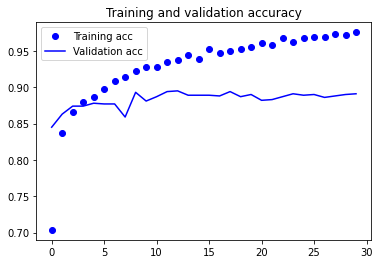

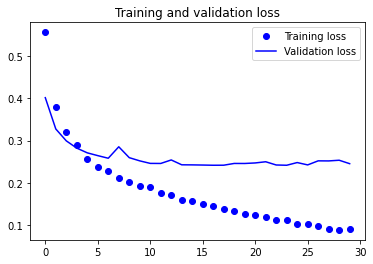

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [20]:
# we need to freeze the convolutional base to ensure that our
# weights are not distorted by the randomly initialized values
# of the dense layer

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False


This is the number of trainable weights before freezing the conv base: 30


In [21]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [22]:
# with this setup only the weights from the two dense layers will be trained
# that's a total of 4 weight tensors, 2 per layer (main weight matrix and the bias vector)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.5907 - acc: 0.6955 - val_loss: 0.3764 - val_acc: 0.7930
Epoch 2/30
 - 20s - loss: 0.4886 - acc: 0.7810 - val_loss: 0.3370 - val_acc: 0.8720
Epoch 3/30
 - 19s - loss: 0.4471 - acc: 0.8050 - val_loss: 0.3251 - val_acc: 0.8480
Epoch 4/30
 - 19s - loss: 0.3954 - acc: 0.8310 - val_loss: 0.4454 - val_acc: 0.8830
Epoch 5/30
 - 19s - loss: 0.3918 - acc: 0.8250 - val_loss: 0.1969 - val_acc: 0.8800
Epoch 6/30
 - 19s - loss: 0.3974 - acc: 0.8190 - val_loss: 0.2672 - val_acc: 0.8930
Epoch 7/30
 - 19s - loss: 0.3793 - acc: 0.8265 - val_loss: 0.3717 - val_acc: 0.8890
Epoch 8/30
 - 19s - loss: 0.3652 - acc: 0.8300 - val_loss: 0.1788 - val_acc: 0.8950
Epoch 9/30
 - 19s - loss: 0.3525 - acc: 0.8440 - val_loss: 0.1507 - val_acc: 0.8710
Epoch 10/30
 - 19s - loss: 0.3379 - acc: 0.8495 - val_loss: 0.3998 - val_acc: 0.8910
Epoch 11/30
 - 19s - loss: 0.3505 - acc: 0.8475 - val_loss: 0.3169 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

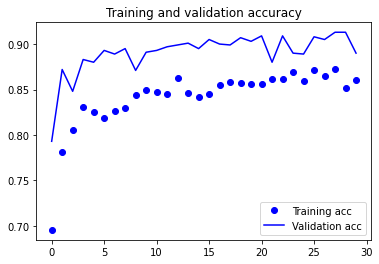

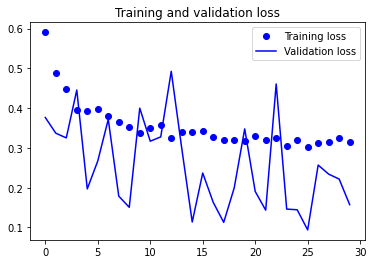

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Fine-tuning : Unfreezing a few top layers of a frozen model base used for feature extraction , and jointly training both the newly added part of the model (the fully connected classifier) and these top layer

This is fine-tuning because it slightly adjusts the more abstract representations of the model being reused to make them more relevant to the model at hand

We only finetune the top layers once the classifier has been trained so as to avoid distorting the already established features of the convnet

STEPS:
- Add your own custom network on top of an already trained base network
-Freeze the base network
-Train the part you added
-Unfreeze some layers in the base network
-Jointly train both these layers and the part you added

In [25]:
# Let's proceed with step 4
# we will unfreeze the conv-base 
# we will then freeze the individual layers inside it

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# We want to finetune the last 3 convolutional layers only
# The smaller the dataset the fewer the convnet layers we need to finetune

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
# proceeding with the finetuning

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 225ms/step - loss: 0.3270 - acc: 0.8535 - val_loss: 0.2413 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2893 - acc: 0.8725 - val_loss: 0.0747 - val_acc: 0.9200
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2680 - acc: 0.8805 - val_loss: 0.2891 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2458 - acc: 0.8935 - val_loss: 0.0651 - val_acc: 0.9400
Epoch 5/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2553 - acc: 0.8920 - val_loss: 0.2369 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 20s 200ms/step - loss: 0.2279 - acc: 0.9020 - val_loss: 0.4046 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2251 - acc: 0.8960 - val_loss: 0.0884 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

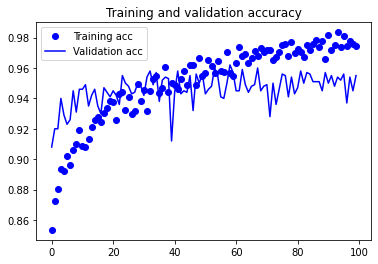

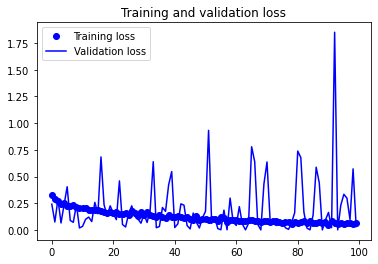

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

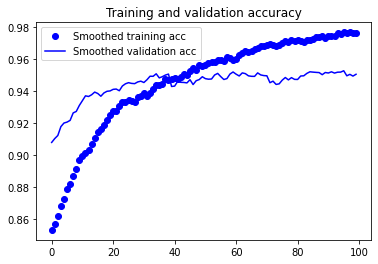

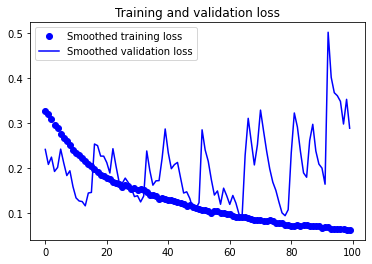

In [30]:
#  This has got to be one of the most useful function that I've seen
# I often get noisy graphs and so this is awesome for readability
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# This code generates the output of the model when evaulated on our test set

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
test acc: 0.9549999833106995
